<a href="https://colab.research.google.com/github/davidenko2000/Computer-Vision-FerUniZg/blob/master/Computer_Vision_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, implementacijska izvedba će biti začajno izazovnija. 

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). Teorijske izvode i dokaze možete napraviti i na papiru kojeg je onda potrebno ponijeti na predaju vježbe.

U slučaju nejasnoća javite se na matej.grcic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) = \underset{\theta}{\mathrm{min}} \int_{-\infty}^{+\infty} p_D(x) \ln\frac{p_D(x)}{p_\theta(x)} dx
$$

$$
= \underset{\theta}{\mathrm{min}} \, \mathbb{E}_{\mathbf{x} \in D} \;\;  \left[\ln \frac{p_D(x)}{p_\theta(x)}\right]
= \underset{\theta}{\mathrm{min}} \, \mathbb{E}_{\mathbf{x} \in D} \;\; [\ln p_D(x) - \ln{p_\theta(x)}]
$$

$$
= \underset{\theta}{\mathrm{min}} \, \mathbb{E}_{\mathbf{x} \in D} \;\; [\ln p_D(x)] - \underset{\theta}{\mathrm{min}} \, \mathbb{E}_{\mathbf{x} \in D} \;\; [\ln{p_\theta(x)}]
$$

kako prvo očekivanje ne ovisi o parametrima $\theta$, možemo ignorirati i dobivamo:

$$
= - \underset{\theta}{\mathrm{min}} \, \mathbb{E}_{\mathbf{x} \in D} \;\; [\ln{p_\theta(x)}]
$$

**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$. 
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right| \\ = q(\mathbf{z}_K) \left| \mathrm{det}  \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right| = q(\mathbf{z}_K) \left| \mathrm{det}  \frac{\partial \mathbf{z}_K}{ \partial \mathbf{z}_{K-1}} …  \frac{\partial \mathbf{z}_k}{ \partial \mathbf{z}_{k-1}} \dots \frac{\partial \mathbf{z}_1}{ \partial \mathbf{x}}\right| \\ = q(\mathbf{z}_K) \left| \mathrm{det}  \frac{\partial \mathbf{z}_K}{ \partial \mathbf{z}_{K-1}} \right| … \left| \mathrm{det}  \frac{\partial \mathbf{z}_k}{ \partial \mathbf{z}_{k-1}} \right| \dots \left| \mathrm{det} \frac{\partial \mathbf{z}_1}{ \partial \mathbf{x}}\right| \\ = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka. 

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [2]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

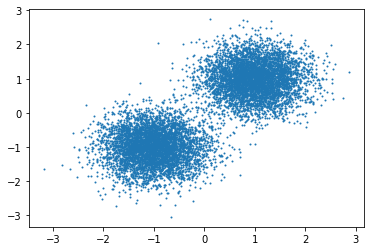

In [3]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [4]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

    def regularization(self):
        return 0.

Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear.
1. Unaprijedni prolaz mora vratiti izlaz sloja te logaritam apsolutne vrijednosti determinante Jakobijana
2. inverzni prolaz mora vratiti ulaz u sloj
3. Transformaciju je potrebno držati invertibilnom s regularzacijskim članom



**Zadatak 3.**: Nadopunite forward i inverse funkciju. 

Hint: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno.

In [31]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

import torch.nn.functional as F

class BijectiveLinear(_Bijection):
    def __init__(self, dim):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))
    
    def forward(self, x):   # x has shape NxD 
        z = F.linear(x, self.weight, self.bias)
        sign, log_abs_det = torch.slogdet(self.weight)

        return z, log_abs_det # shapes NxD, N

    def inverse(self, z):
        weight_inv = torch.inverse(self.weight)
        z = z - self.bias
        x = F.linear(z, weight_inv)
        return x    # NxD

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()




Normalizirajući tok implementiramo sljedećim kodom. Primjetite da direktno računamo $\ln p_\theta(\mathbf{x})$.

In [5]:
class _NormalizingFlow(nn.Module):
    def __init__(self):
        super(_NormalizingFlow, self).__init__()

    def log_prob(self, x):
        pass

    
    def forward(self, x):
        pass

    def inverse(self, z):
        pass

    def sample(self, num_samples):
        pass


class SimpleNF(_NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        super(SimpleNF, self).__init__()
        self.transforms = nn.Sequential()
        for _ in range(num_steps):
            self.transforms.append(BijectiveLinear(input_dim))
            
        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        log_pz = self.z_dist().log_prob(z).sum(-1)
        log_px =  + log_pz + log_abs_det
        return log_px

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])
    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

Provjerite svoju implementaciju inverza sljedećim kodom:

In [28]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).sum().item())
assert (flow.inverse(flow(D)) - D).sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [32]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.546642303466797 Reg:3.0696523189544678
Iter 41: Loss:2.5819005966186523 Reg:3.0879862308502197
Iter 61: Loss:2.549468994140625 Reg:3.1975088119506836
Iter 81: Loss:2.5468554496765137 Reg:3.202178955078125
Iter 101: Loss:2.5466535091400146 Reg:3.1987216472625732
Iter 121: Loss:2.546635150909424 Reg:3.194823980331421
Iter 141: Loss:2.546633005142212 Reg:3.1910135746002197
Iter 161: Loss:2.546633243560791 Reg:3.1873183250427246
Iter 181: Loss:2.546632766723633 Reg:3.183737277984619
Iter 201: Loss:2.546632766723633 Reg:3.1802618503570557
Iter 221: Loss:2.546633005142212 Reg:3.176891326904297
Iter 241: Loss:2.546633005142212 Reg:3.173621892929077
Iter 261: Loss:2.5466325283050537 Reg:3.1704483032226562
Iter 281: Loss:2.546632766723633 Reg:3.1673707962036133
Iter 301: Loss:2.546632766723633 Reg:3.164383888244629
Iter 321: Loss:2.546632766723633 Reg:3.1614866256713867
Iter 341: Loss:2.546632766723633 Reg:3.158675193786621
Iter 361: Loss:

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [33]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(-3.5387e-05, grad_fn=<SumBackward0>)


Generiranje primjera s normalizirajućim tokom.

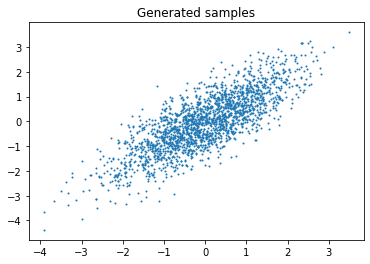

In [34]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

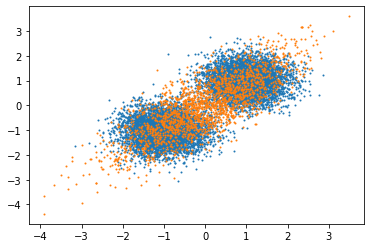

In [35]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Definirani tok je prilično jednostavan stoga ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju performansu dobiti ćemo s kapacitetnijim tokom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od Coupling slojeva koji su invertibilni po konstrukciji.

Unaprijedni prolaz kroz afini coupling sloj s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 4.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afini coupling sloj. Zatim, nadopunite postojeći AffineCouplingLayer s prikladnom funkcionalnošću.

In [37]:

class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net
        self.m = net.dim

    def forward(self, x): # NxD
        z1, x2 = torch.split(x, (self.m, x.shape[1] - self.m), dim=1)
        log_s, t = self.net(z1)
        z2, log_det = torch.exp(log_s) * x2 + t, sum_except_batch(log_s)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det # NxD , N

    def inverse(self, y): # NxD
        with torch.no_grad():
          x1, z2 = torch.split(y, (self.m, y.shape[1] - self.m), dim=1)
          log_s, t = self.net(x1)
          x2 = (z2 - t) / torch.exp(log_s) 
          x = torch.cat([x1, x2], dim=1)
        return x # NxD

class SwitchSides(_Bijection):

    def forward(self, x):
        x1, x2 = torch.chunk(x, dim=1, chunks=2)
        y = torch.cat((x2, x1), 1)
        return y, 0.

    def inverse(self, z):
        x1, x2 = torch.chunk(z, dim=1, chunks=2)
        x = torch.cat((x2, x1), 1)
        return x


class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=2):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2 * dim),
        )
        nn.init.zeros_(self.model[-1].weight)
        nn.init.zeros_(self.model[-1].bias)


    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t



class RealNVP(_NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        super(RealNVP, self).__init__()
        self.transforms = nn.Sequential()
        for i in range(num_steps):
            self.transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                self.transforms.append(SwitchSides())
        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        log_pz = self.z_dist().log_prob(z).sum(-1)
        log_px =  + log_pz + log_abs_det
        return log_px

    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x


In [38]:
flow = RealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(2000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:2.9265594482421875
Iter 41: Loss:2.59616756439209
Iter 61: Loss:2.4498908519744873
Iter 81: Loss:2.418381929397583
Iter 101: Loss:2.400139093399048
Iter 121: Loss:2.386923313140869
Iter 141: Loss:2.377408981323242
Iter 161: Loss:2.3705780506134033
Iter 181: Loss:2.3655924797058105
Iter 201: Loss:2.361811399459839
Iter 221: Loss:2.3584864139556885
Iter 241: Loss:2.3552660942077637
Iter 261: Loss:2.351653575897217
Iter 281: Loss:2.3470616340637207
Iter 301: Loss:2.3409948348999023
Iter 321: Loss:2.3331027030944824
Iter 341: Loss:2.3235559463500977
Iter 361: Loss:2.3130102157592773
Iter 381: Loss:2.3025741577148438
Iter 401: Loss:2.292947769165039
Iter 421: Loss:2.284425735473633
Iter 441: Loss:2.2769992351531982
Iter 461: Loss:2.2705061435699463
Iter 481: Loss:2.264725923538208
Iter 501: Loss:2.259387493133545
Iter 521: Loss:2.2545242309570312
Iter 541: Loss:2.2503163814544678
Iter 561: Loss:2.246506452560425
Iter 581: Loss:2.242952346801758


In [39]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(4.0009e-05)


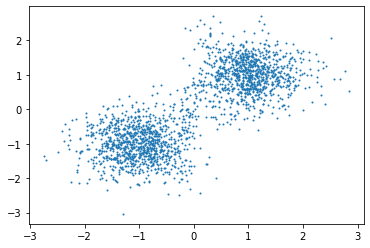

In [40]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

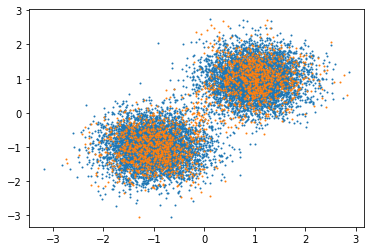

In [41]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

In [42]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [43]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()])) 

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [44]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

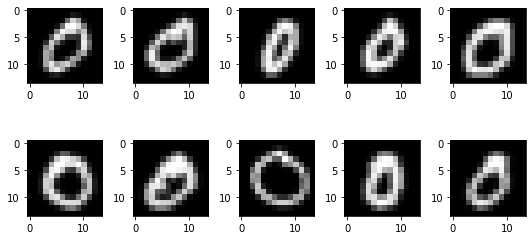

In [45]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

In [46]:
import torch


class Squeeze2d(_Bijection):
    def __init__(self, factor=2):
        super(Squeeze2d, self).__init__()
        assert isinstance(factor, int)
        assert factor > 1
        self.factor = factor

    def _squeeze(self, x):
        assert len(x.shape) == 4, 'Dimension should be 4, but was {}'.format(len(x.shape))
        batch_size, c, h, w = x.shape
        assert h % self.factor == 0, 'h = {} not multiplicative of {}'.format(h, self.factor)
        assert w % self.factor == 0, 'w = {} not multiplicative of {}'.format(w, self.factor)
        t = x.view(batch_size, c, h // self.factor, self.factor, w // self.factor, self.factor)
        t = t.permute(0, 1, 3, 5, 2, 4).contiguous()

        z = t.view(batch_size, c * self.factor ** 2, h // self.factor, w // self.factor)
        return z

    def _unsqueeze(self, z):
        assert len(z.shape) == 4, 'Dimension should be 4, but was {}'.format(len(z.shape))
        batch_size, c, h, w = z.shape
        assert c % (self.factor ** 2) == 0, 'c = {} not multiplicative of {}'.format(c, self.factor ** 2)
        t = z.view(batch_size, c // self.factor ** 2, self.factor, self.factor, h, w)
        t = t.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = t.view(batch_size, c // self.factor ** 2, h * self.factor, w * self.factor)
        return x

    def forward(self, x):
        z = self._squeeze(x)
        ldj = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
        return z, ldj

    def inverse(self, z):
        x = self._unsqueeze(z)
        return x

**Zadatak 5.:** Nadopunite AffineCouplingLayer2d te oblikujte SimpleTransform2d s proizvoljnim transformacijama tako da normalizirajući tok može naučiti podskup MNIST slika. 


In [64]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels):
        super(ResidualLayer, self).__init__()

        layers = []

        layers.extend([
            nn.Conv2d(in_channels, in_channels, kernel_size=3,
                      stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True),
        ])

        layers.extend([
            nn.Conv2d(in_channels, in_channels, kernel_size=3,
                      stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True)
        ])

        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        h = self.nn(x)
        return h


class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(GatedConv2d, self).__init__()
        self.in_channels = in_channels
        self.conv = nn.Conv2d(in_channels, out_channels * 3,
                              kernel_size=kernel_size, padding=padding)

    def forward(self, x):
        h = self.conv(x)
        a, b, c = torch.chunk(h, chunks=3, dim=1)
        return a + b * torch.sigmoid(c)


class Residual(nn.Sequential):
    def __init__(self, in_channels, out_channels, gated_conv=False, zero_init=False):

        layers = [ResidualLayer(in_channels)]

        if gated_conv:
            layers.append(GatedConv2d(in_channels, out_channels, kernel_size=1, padding=0))
        else:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

        if zero_init:
            nn.init.zeros_(layers[-1].weight)
            if hasattr(layers[-1], 'bias'):
                nn.init.zeros_(layers[-1].bias)

        super(Residual, self).__init__(*layers)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 dropout=0.0, gated_conv=False, zero_init=False):
        super(ResidualBlock, self).__init__()

        self.rb = Residual(in_channels=in_channels,
                                out_channels=out_channels,
                                gated_conv=gated_conv,
                                zero_init=zero_init)

    def forward(self, x):
        return x + self.rb(x)

In [66]:
from numpy.lib.function_base import append
class AffineCouplingLayer2d(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer2d, self).__init__()
        self.net = net
        self.m = net.dim

    def forward(self, x): # NxCxHxW
        z1, x2 = torch.split(x, (self.m, x.shape[1] - self.m), dim=1)
        log_s, t = self.net(z1)
        z2, log_det = torch.exp(log_s) * x2 + t, sum_except_batch(log_s)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det # NxCxHxW , N

    def inverse(self, y): # NxCxHxW
        with torch.no_grad():
          x1, z2 = torch.split(y, (self.m, y.shape[1] - self.m), dim=1)
          log_s, t = self.net(x1)
          x2 = (z2 - t) / torch.exp(log_s) 
          x = torch.cat([x1, x2], dim=1)
        return x # NxD


class SimpleTransform2d(nn.Module):
    def __init__(self, dim, inflate_coef=2):
        super(SimpleTransform2d, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Conv2d(dim, internal_dim, kernel_size=1),
        )
        for _ in range(1):
          self.model.append(
              ResidualBlock(in_channels=internal_dim, out_channels=internal_dim,
                            gated_conv=True)
          )
        self.model.append(
            nn.Conv2d(internal_dim, 2 * dim, kernel_size=1,)
        )
        """
        self.model = nn.Sequential(
            #nn.Conv2d(dim, internal_dim, kernel_size=1),
            #nn.ReLU(),
            nn.Conv2d(internal_dim, internal_dim, kernel_size=3,
                      stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True),

            
            nn.Conv2d(internal_dim, internal_dim, kernel_size=3,
                      stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True),

            # umetnite slojeve ovdje
            nn.Conv2d(internal_dim, 2 * dim, kernel_size=1),
        )"""
        nn.init.zeros_(self.model[-1].weight)
        nn.init.zeros_(self.model[-1].bias)


    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t



class RealNVPMNIST(_NormalizingFlow):
    def __init__(self, channels, image_shape, num_steps=2, blocks=2):
        super(RealNVPMNIST, self).__init__()
        num_dims = image_shape[0] * image_shape[1] * channels
        self.transforms = nn.Sequential()

        for _ in range(blocks):
            self.transforms.append(Squeeze2d())
            channels = channels * 4
            image_shape = (image_shape[0] // 2, image_shape[1] // 2) 
            for i in range(num_steps):
                self.transforms.append(AffineCouplingLayer2d(SimpleTransform2d(channels//2)))
                if i != num_steps-1:
                    self.transforms.append(SwitchSides())

        self.register_buffer('loc', torch.zeros(num_dims))
        self.register_buffer('log_scale', torch.zeros(num_dims))
        self.channels = channels
        self.image_shape = image_shape

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        
        z = z.view(z.shape[0], -1)
        log_pz = sum_except_batch(self.z_dist().log_prob(z))
        log_px =  + log_pz + log_abs_det
        return log_px

    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        z = z.reshape(num_samples, self.channels ,*self.image_shape)
        x = self.inverse(z)
        return x


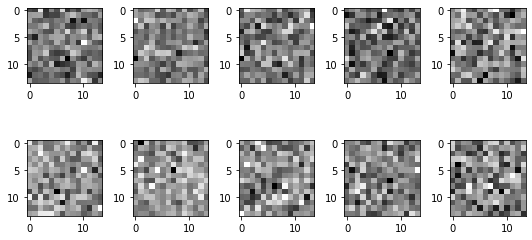

Epoch 1: Train Loss:1267.5951940658244 Val BPD: 9.251132011413574


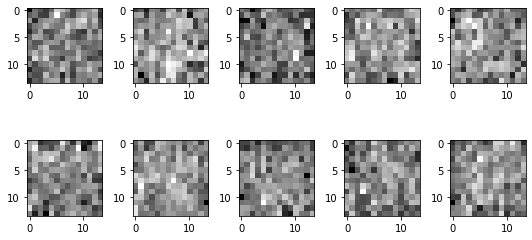

Epoch 11: Train Loss:1064.510734395778 Val BPD: 7.780913829803467


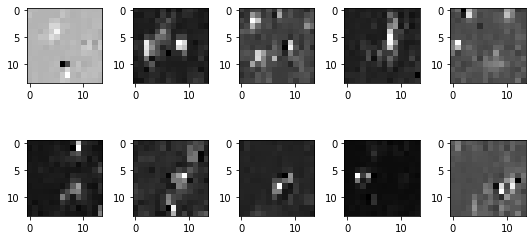

Epoch 21: Train Loss:783.7665015687334 Val BPD: 5.721063137054443


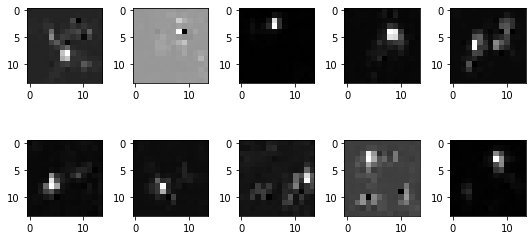

Epoch 31: Train Loss:650.284532912234 Val BPD: 4.7425689697265625


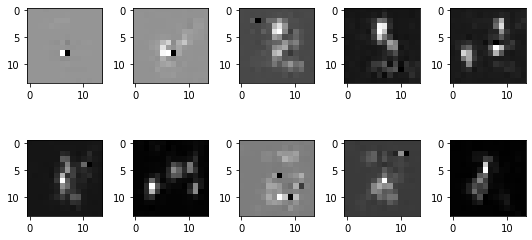

Epoch 41: Train Loss:583.1369109458112 Val BPD: 4.2592620849609375


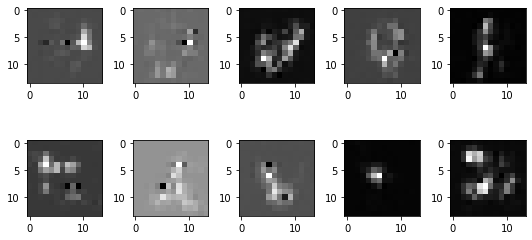

Epoch 51: Train Loss:552.2383838410074 Val BPD: 4.036722183227539


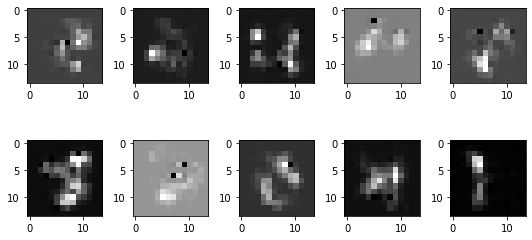

Epoch 61: Train Loss:533.9437437666223 Val BPD: 3.9044272899627686


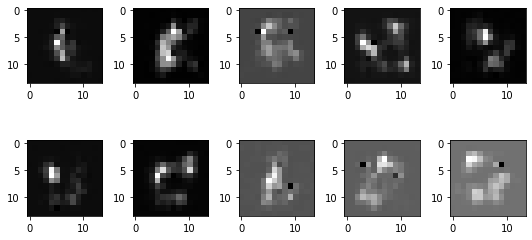

Epoch 71: Train Loss:521.3047784034242 Val BPD: 3.8084523677825928


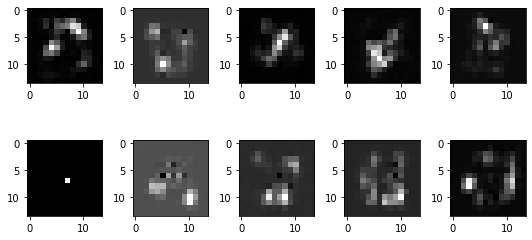

Epoch 81: Train Loss:510.9323762934259 Val BPD: 3.7368061542510986


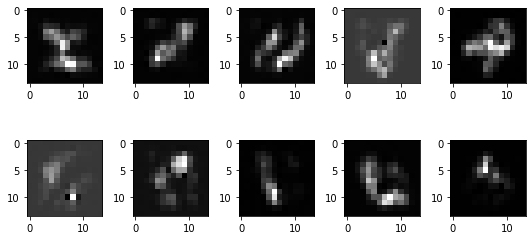

Epoch 91: Train Loss:502.6550526720412 Val BPD: 3.6749088764190674


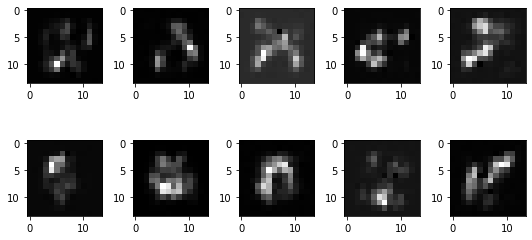

Epoch 101: Train Loss:495.44254124418217 Val BPD: 3.62402081489563


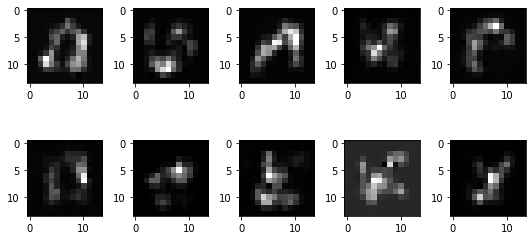

Epoch 111: Train Loss:489.0813157101895 Val BPD: 3.575394868850708


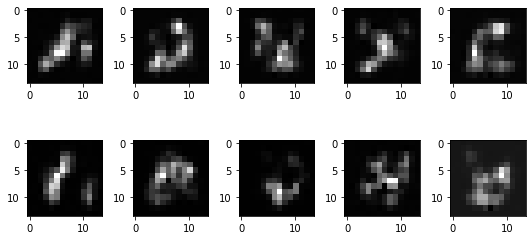

Epoch 121: Train Loss:482.85810949447307 Val BPD: 3.5312225818634033


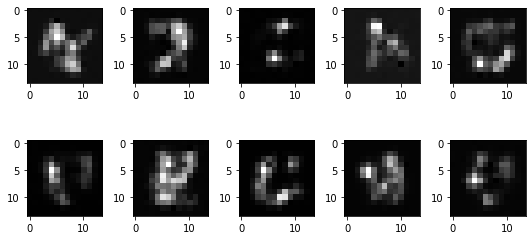

Epoch 131: Train Loss:477.5507357982879 Val BPD: 3.487501621246338


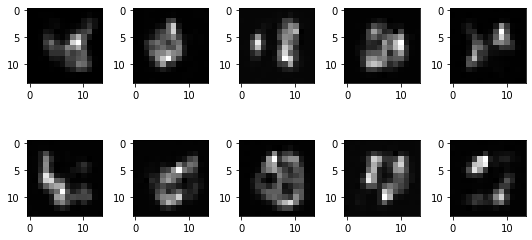

Epoch 141: Train Loss:472.16736619015956 Val BPD: 3.4514222145080566


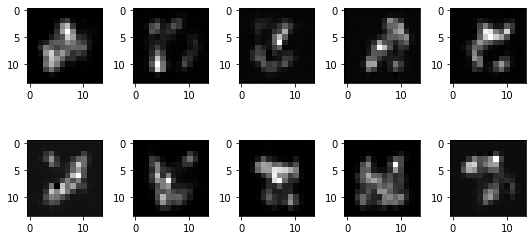

Epoch 151: Train Loss:467.28195709877826 Val BPD: 3.420229196548462


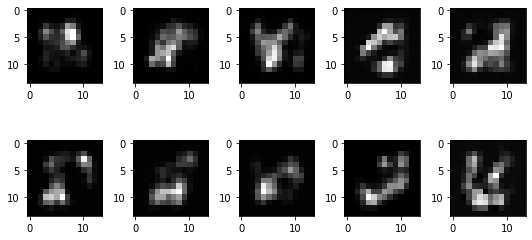

Epoch 161: Train Loss:463.2787378189412 Val BPD: 3.3871545791625977


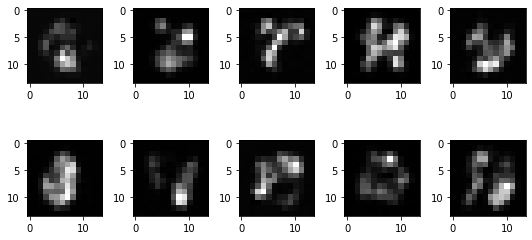

Epoch 171: Train Loss:459.07507389149765 Val BPD: 3.3599448204040527


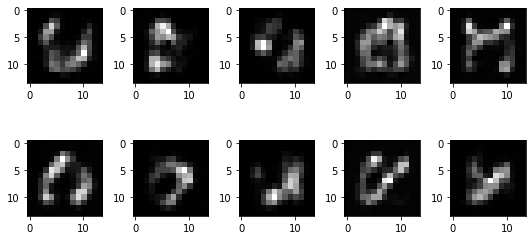

Epoch 181: Train Loss:455.8496853442902 Val BPD: 3.3312008380889893


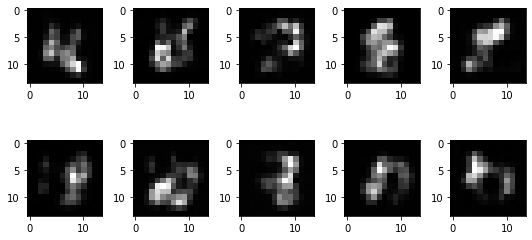

Epoch 191: Train Loss:452.3052394136469 Val BPD: 3.308643102645874


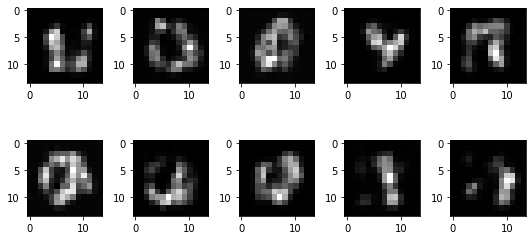

Epoch 201: Train Loss:449.44779026761967 Val BPD: 3.2906179428100586


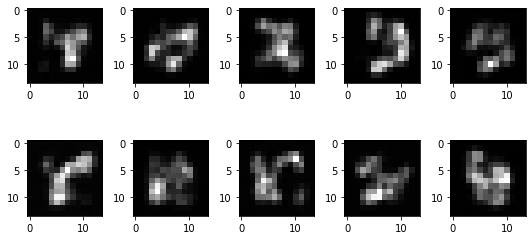

Epoch 211: Train Loss:446.64443450278424 Val BPD: 3.2692370414733887


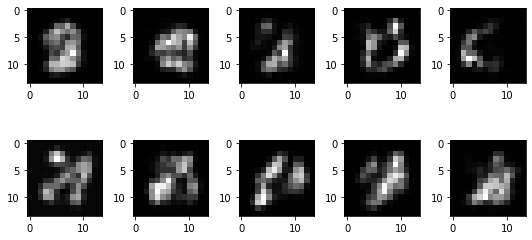

Epoch 221: Train Loss:443.86074569377496 Val BPD: 3.249937057495117


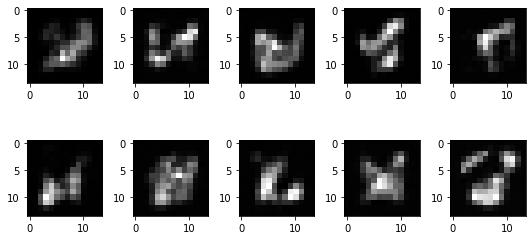

Epoch 231: Train Loss:441.3670251724568 Val BPD: 3.230851650238037


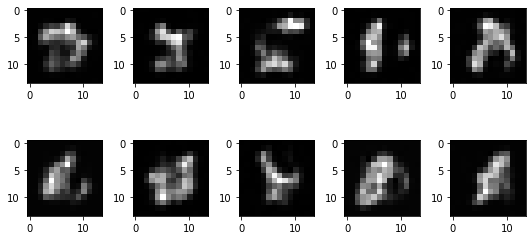

Epoch 241: Train Loss:439.02164150806186 Val BPD: 3.2157950401306152


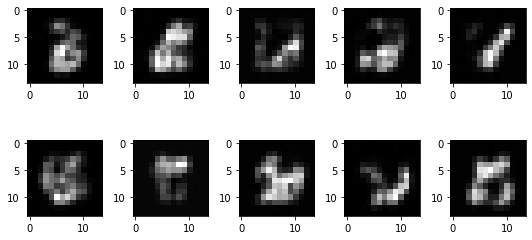

Epoch 251: Train Loss:437.1515944460605 Val BPD: 3.1995415687561035


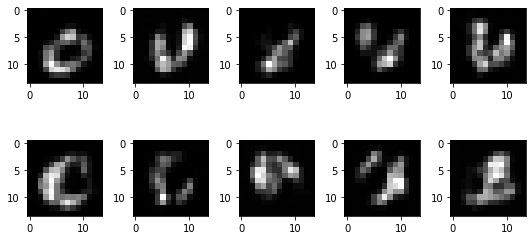

Epoch 261: Train Loss:435.0410513370595 Val BPD: 3.188663959503174


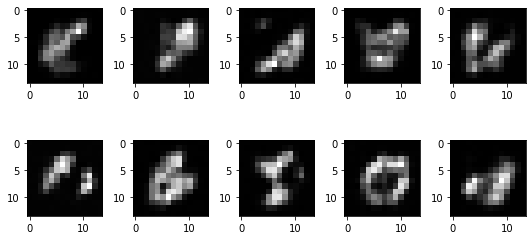

Epoch 271: Train Loss:433.80669646567486 Val BPD: 3.1742069721221924


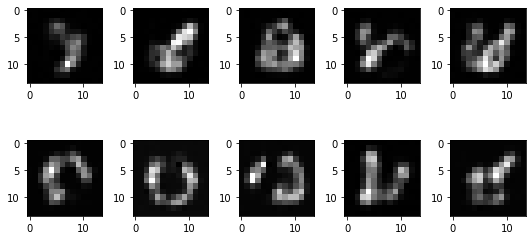

Epoch 281: Train Loss:432.03653863135804 Val BPD: 3.1644842624664307


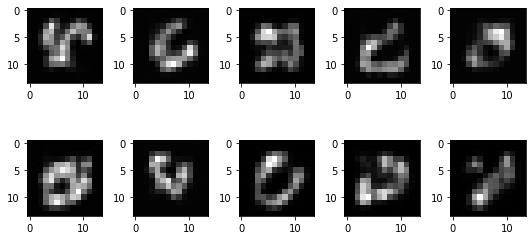

Epoch 291: Train Loss:430.65079319730717 Val BPD: 3.1561813354492188


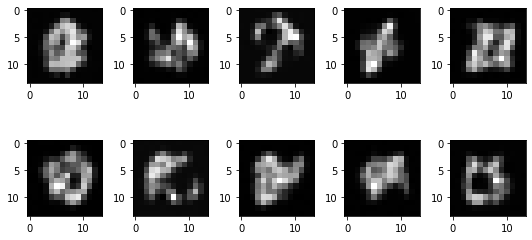

Epoch 301: Train Loss:429.22041223404256 Val BPD: 3.140467643737793


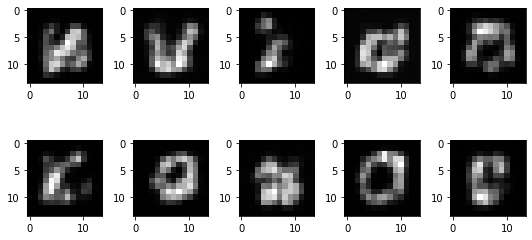

Epoch 311: Train Loss:427.99877345308346 Val BPD: 3.133652687072754


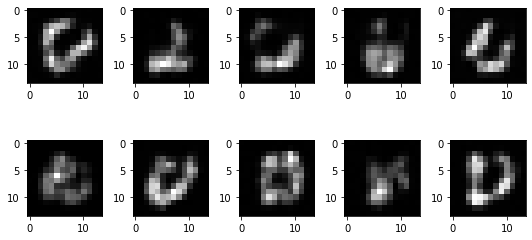

Epoch 321: Train Loss:427.0903690419299 Val BPD: 3.1263675689697266


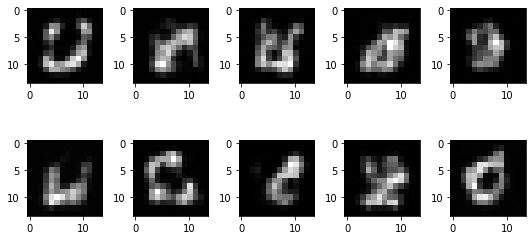

Epoch 331: Train Loss:425.870256139877 Val BPD: 3.118391752243042


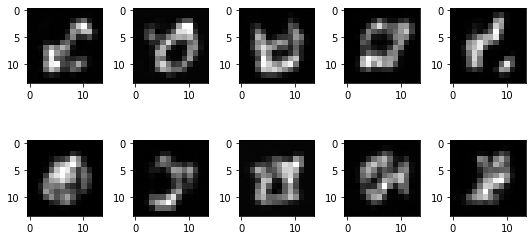

Epoch 341: Train Loss:425.34180466672206 Val BPD: 3.1156728267669678


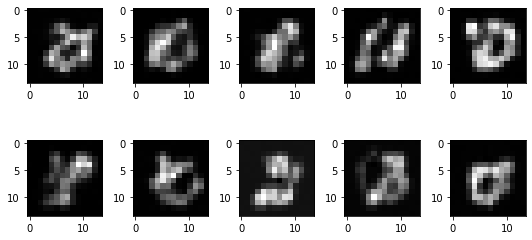

Epoch 351: Train Loss:424.21860260659076 Val BPD: 3.1058993339538574


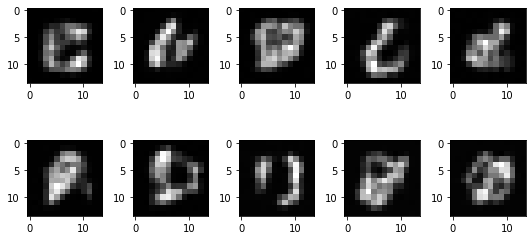

Epoch 361: Train Loss:423.26468350024936 Val BPD: 3.0992543697357178


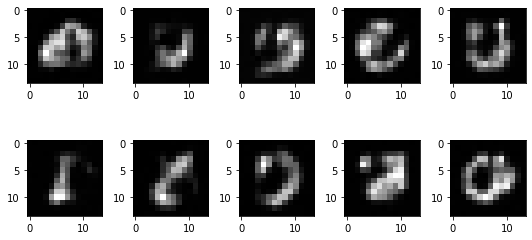

Epoch 371: Train Loss:422.574831049493 Val BPD: 3.094722270965576


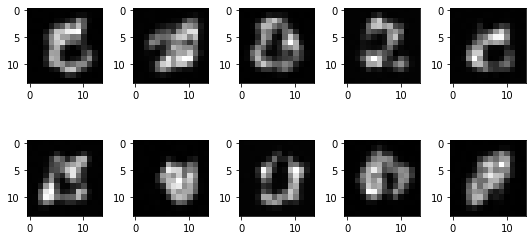

Epoch 381: Train Loss:421.8757538491107 Val BPD: 3.0923850536346436


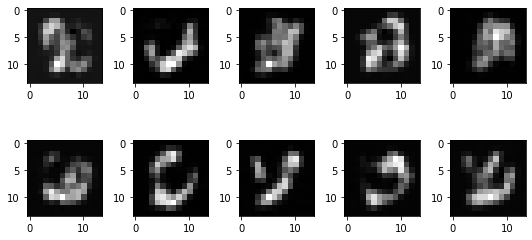

Epoch 391: Train Loss:421.48920586768617 Val BPD: 3.083526134490967


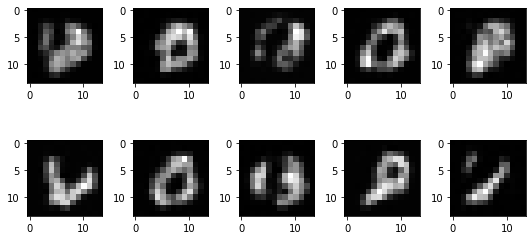

Epoch 401: Train Loss:420.6126949229139 Val BPD: 3.0778369903564453


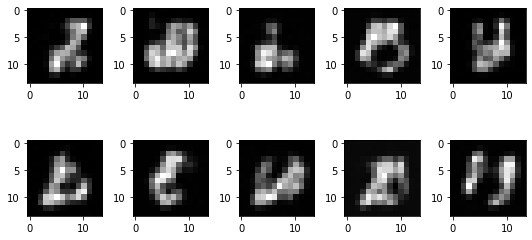

Epoch 411: Train Loss:419.79185842960436 Val BPD: 3.078845739364624


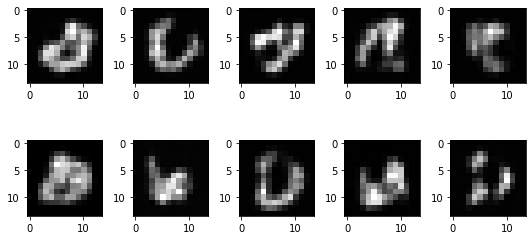

Epoch 421: Train Loss:419.00006817756815 Val BPD: 3.069293975830078


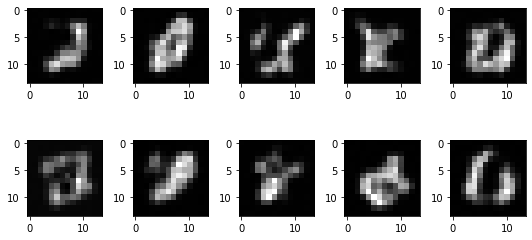

Epoch 431: Train Loss:418.7849666514295 Val BPD: 3.0672364234924316


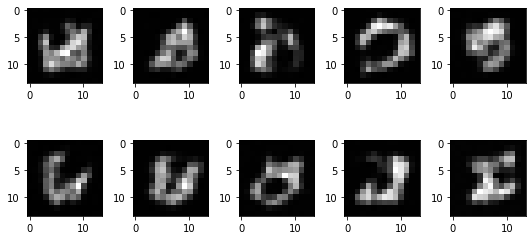

Epoch 441: Train Loss:418.1310626090841 Val BPD: 3.0630741119384766


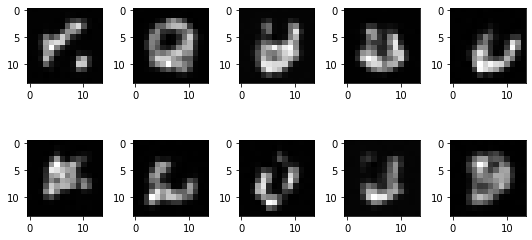

Epoch 451: Train Loss:417.62869002971246 Val BPD: 3.057143449783325


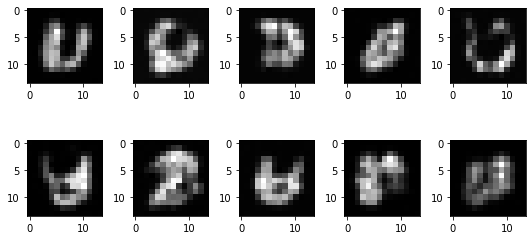

Epoch 461: Train Loss:416.910817247756 Val BPD: 3.0529322624206543


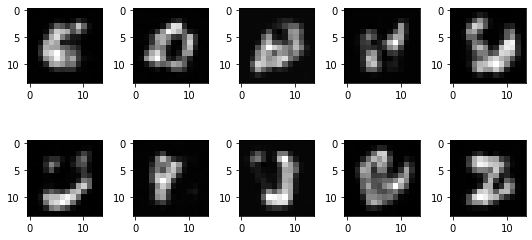

Epoch 471: Train Loss:416.48059536548374 Val BPD: 3.0504250526428223


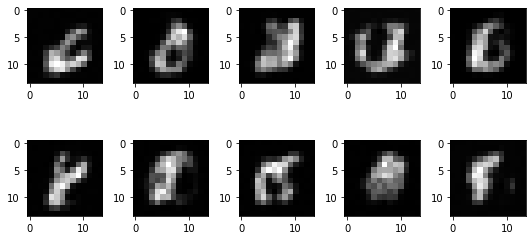

Epoch 481: Train Loss:416.1204502836187 Val BPD: 3.048352003097534


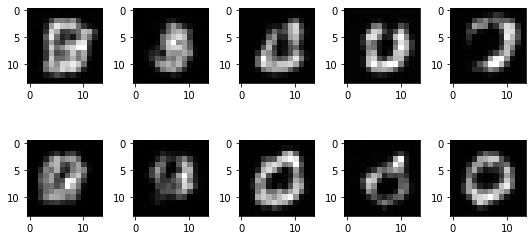

Epoch 491: Train Loss:415.58983790620846 Val BPD: 3.042912006378174


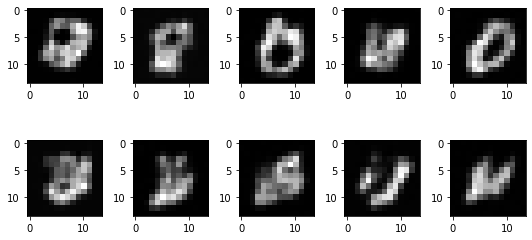

Epoch 501: Train Loss:414.82010277281415 Val BPD: 3.042229652404785


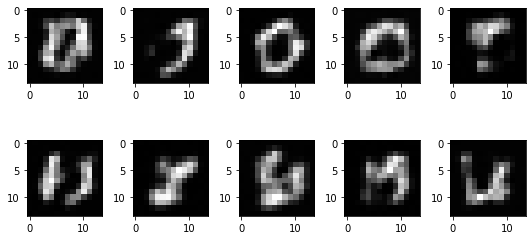

Epoch 511: Train Loss:414.65443972323806 Val BPD: 3.03564453125


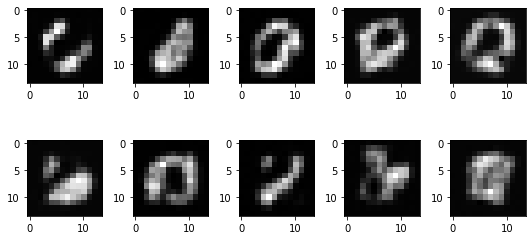

Epoch 521: Train Loss:413.8895049399518 Val BPD: 3.035588264465332


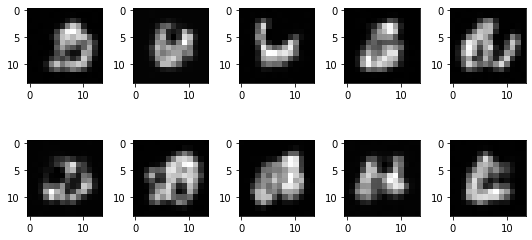

Epoch 531: Train Loss:413.40844272045376 Val BPD: 3.0337369441986084


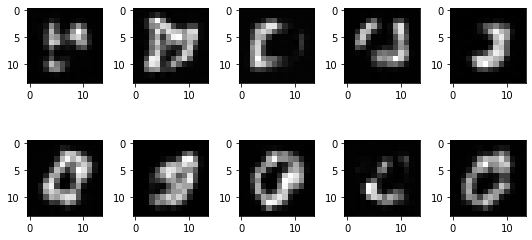

Epoch 541: Train Loss:413.2591448844747 Val BPD: 3.0287680625915527


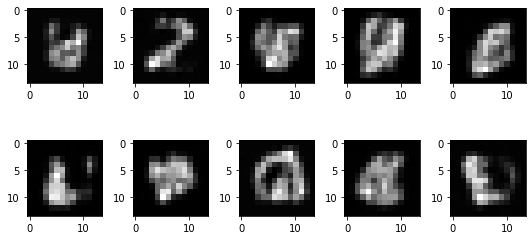

Epoch 551: Train Loss:412.5563218137051 Val BPD: 3.0219478607177734


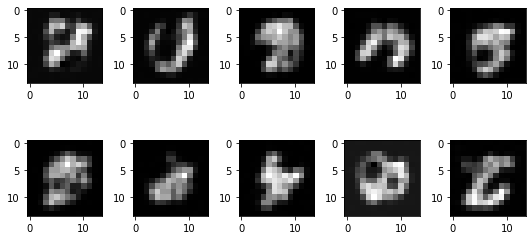

Epoch 561: Train Loss:412.220038231383 Val BPD: 3.0215888023376465


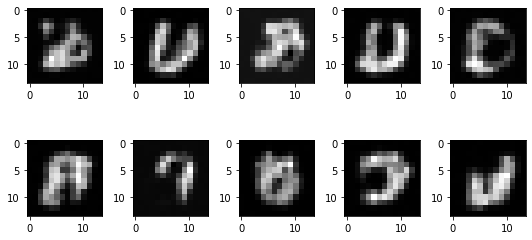

Epoch 571: Train Loss:412.2818986608627 Val BPD: 3.0204434394836426


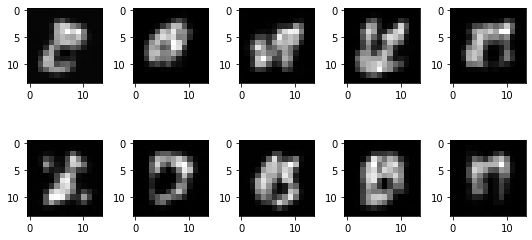

Epoch 581: Train Loss:411.44596635534407 Val BPD: 3.0181636810302734


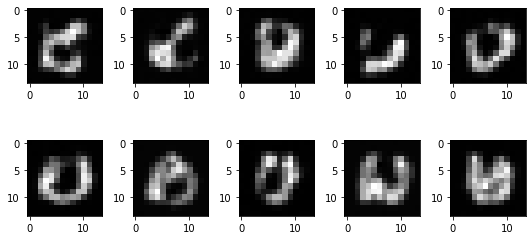

Epoch 591: Train Loss:411.23255563289564 Val BPD: 3.0134449005126953


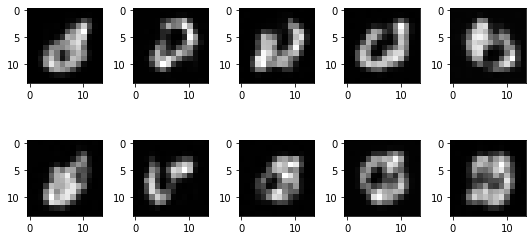

Epoch 601: Train Loss:410.81151564577794 Val BPD: 3.0157899856567383


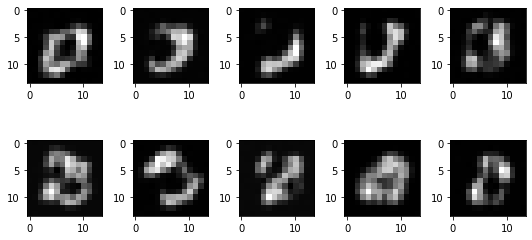

Epoch 611: Train Loss:410.4921771110372 Val BPD: 3.0130200386047363


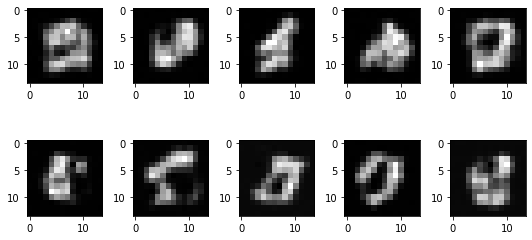

Epoch 621: Train Loss:410.1839313912899 Val BPD: 3.004399538040161


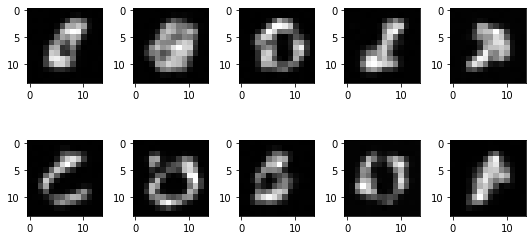

Epoch 631: Train Loss:409.8909678357713 Val BPD: 3.002466917037964


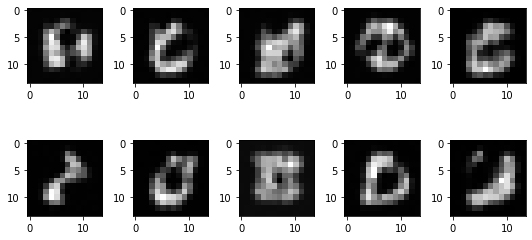

Epoch 641: Train Loss:409.54679968001994 Val BPD: 3.0019454956054688


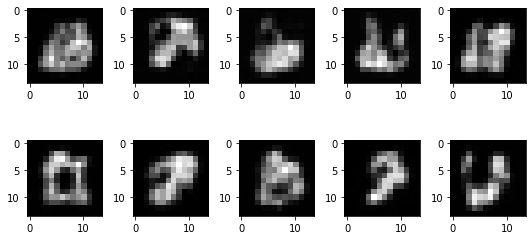

Epoch 651: Train Loss:409.41817133477394 Val BPD: 2.999234676361084


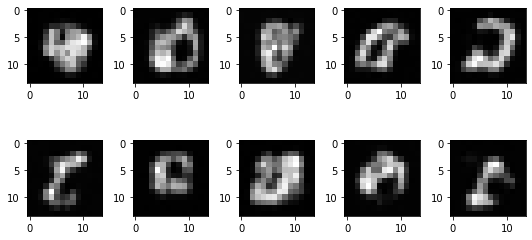

Epoch 661: Train Loss:409.0998703976895 Val BPD: 2.998866081237793


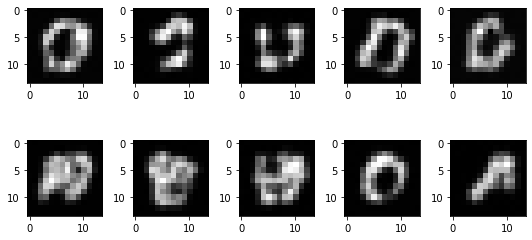

Epoch 671: Train Loss:408.70901229533746 Val BPD: 2.99406099319458


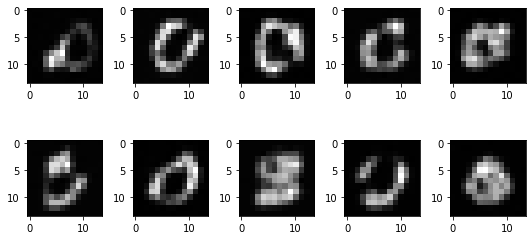

Epoch 681: Train Loss:408.5095520019531 Val BPD: 2.994661569595337


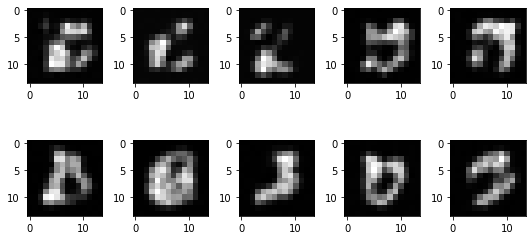

Epoch 691: Train Loss:407.7945985185339 Val BPD: 2.992581367492676


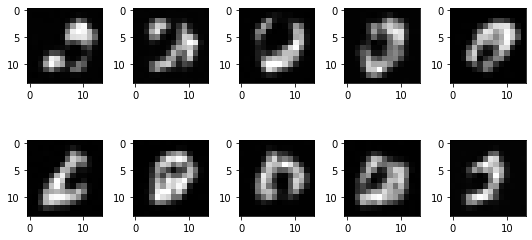

Epoch 701: Train Loss:408.10165535135474 Val BPD: 2.9890432357788086


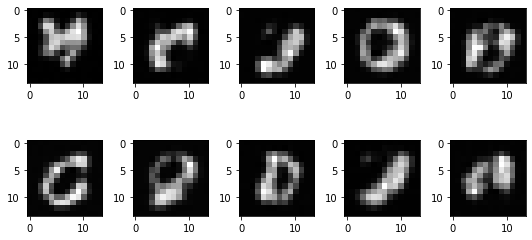

Epoch 711: Train Loss:407.71923243745846 Val BPD: 2.989363670349121


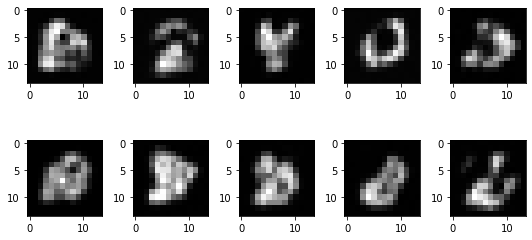

Epoch 721: Train Loss:407.3495035374418 Val BPD: 2.9885430335998535


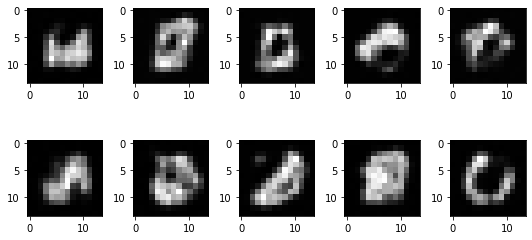

Epoch 731: Train Loss:407.37461560837767 Val BPD: 2.9845852851867676


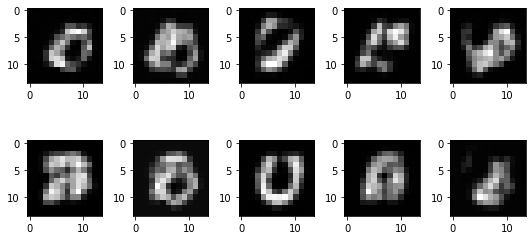

Epoch 741: Train Loss:406.6499568858045 Val BPD: 2.979919195175171


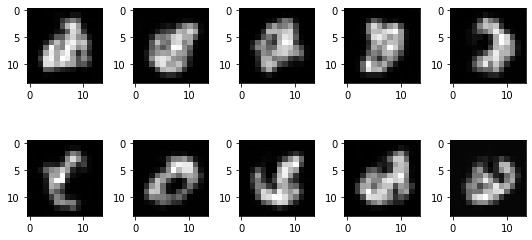

Epoch 751: Train Loss:406.5509883799451 Val BPD: 2.982706308364868


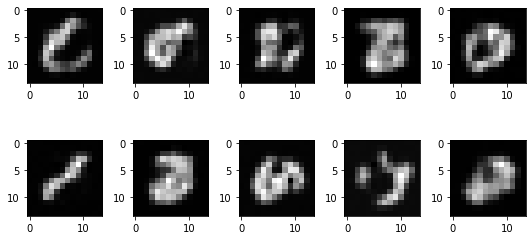

Epoch 761: Train Loss:406.5920215363198 Val BPD: 2.9805450439453125


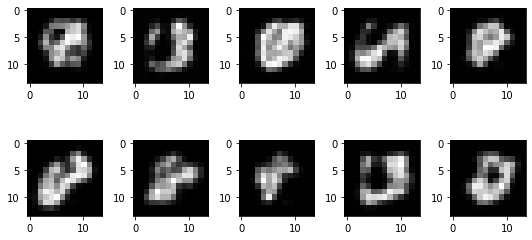

Epoch 771: Train Loss:406.18607866003157 Val BPD: 2.975769519805908


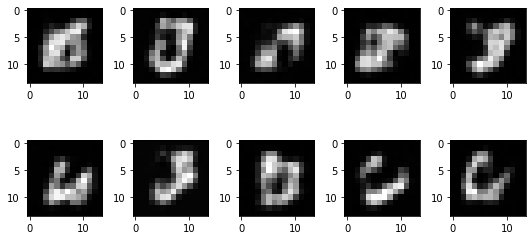

Epoch 781: Train Loss:405.91019261136967 Val BPD: 2.9803266525268555


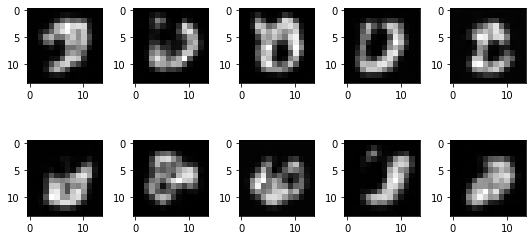

Epoch 791: Train Loss:405.66781746072974 Val BPD: 2.9709529876708984


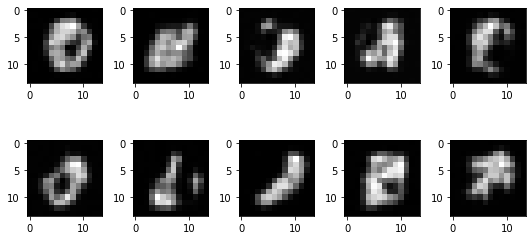

Epoch 801: Train Loss:405.31213508768286 Val BPD: 2.976440668106079


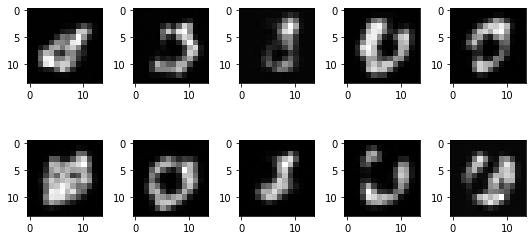

Epoch 811: Train Loss:405.10840622922206 Val BPD: 2.971771717071533


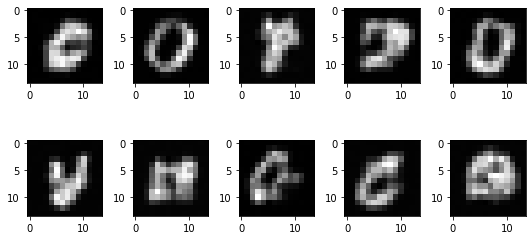

Epoch 821: Train Loss:404.97250625935004 Val BPD: 2.969270706176758


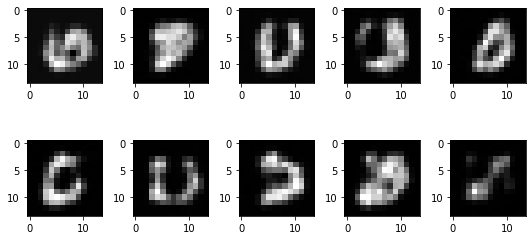

Epoch 831: Train Loss:404.8133382594332 Val BPD: 2.970350503921509


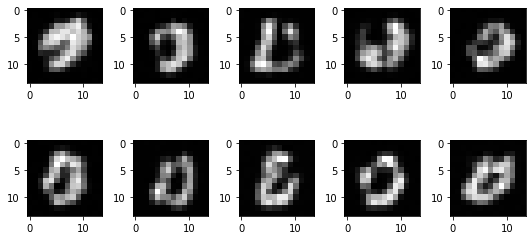

Epoch 841: Train Loss:404.5357042677859 Val BPD: 2.9660518169403076


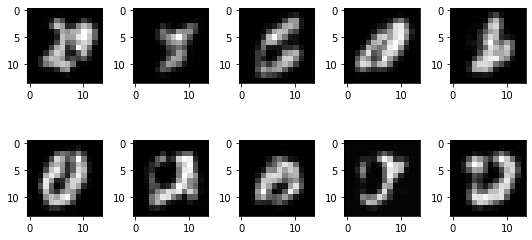

Epoch 851: Train Loss:404.3096891362616 Val BPD: 2.9640767574310303


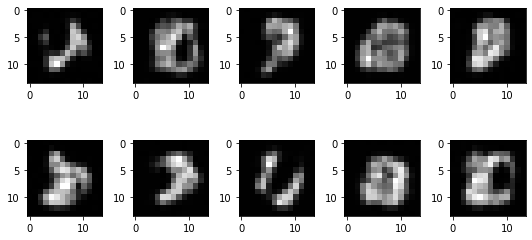

Epoch 861: Train Loss:404.17677339594417 Val BPD: 2.96264910697937


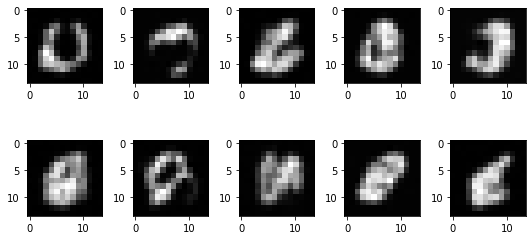

Epoch 871: Train Loss:403.9693674939744 Val BPD: 2.96651029586792


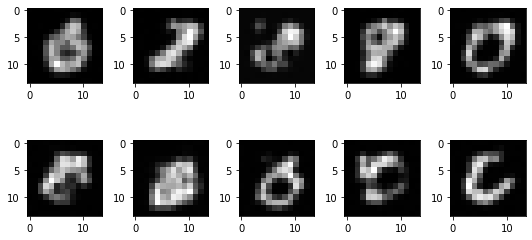

Epoch 881: Train Loss:403.94034397855717 Val BPD: 2.9630653858184814


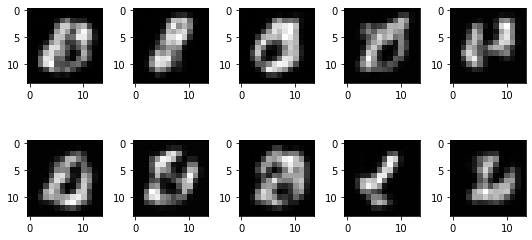

Epoch 891: Train Loss:403.8221065440076 Val BPD: 2.9574294090270996


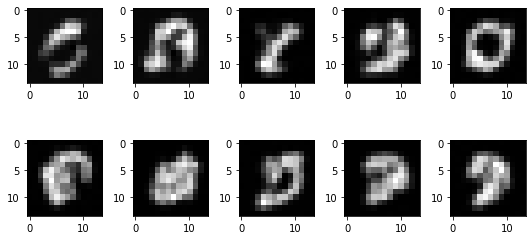

Epoch 901: Train Loss:403.66490855115524 Val BPD: 2.9574670791625977


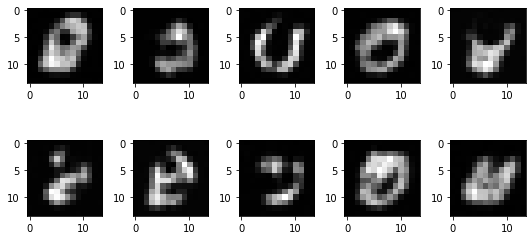

Epoch 911: Train Loss:403.1801829236619 Val BPD: 2.956178665161133


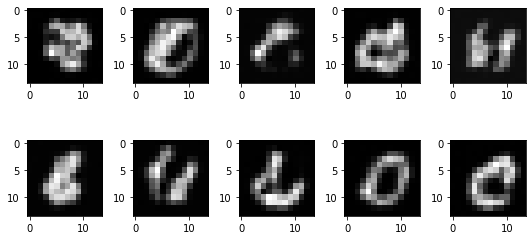

Epoch 921: Train Loss:403.32508882563167 Val BPD: 2.9536478519439697


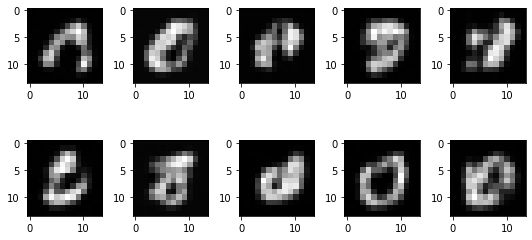

Epoch 931: Train Loss:403.0248711768617 Val BPD: 2.958531618118286


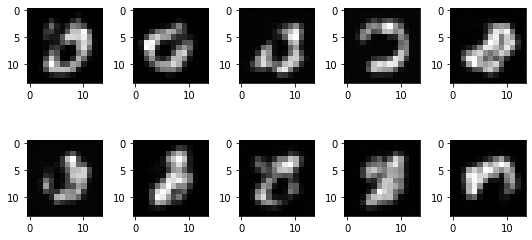

Epoch 941: Train Loss:402.78526663272936 Val BPD: 2.9543094635009766


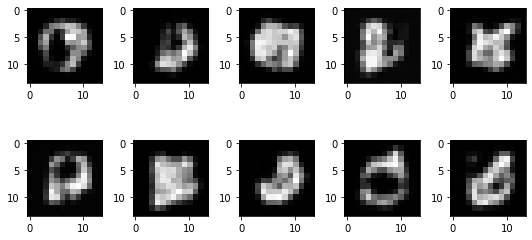

Epoch 951: Train Loss:402.5872426134475 Val BPD: 2.9527766704559326


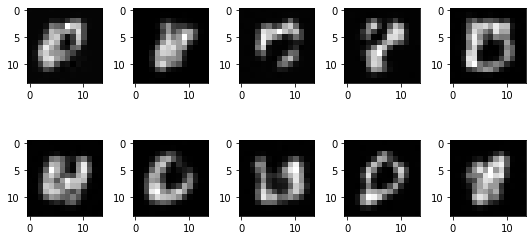

Epoch 961: Train Loss:402.5680749771443 Val BPD: 2.95261549949646


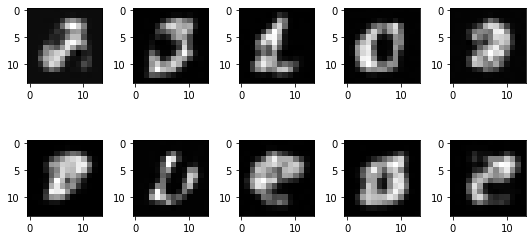

Epoch 971: Train Loss:402.16979201296544 Val BPD: 2.9498913288116455


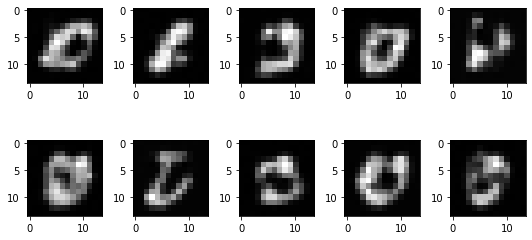

Epoch 981: Train Loss:402.19192959399936 Val BPD: 2.9489195346832275


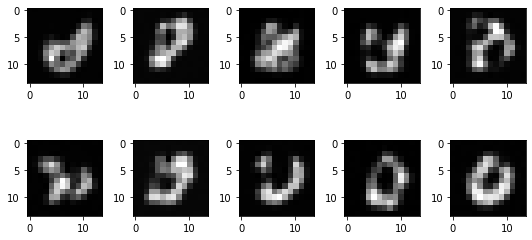

Epoch 991: Train Loss:402.31615626558346 Val BPD: 2.950913429260254


In [67]:
device = 'cuda'
image_shape = (14, 14)
flow = RealNVPMNIST(1, image_shape, num_steps=15, blocks=1).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-4)
epochs = 1000
bits = 8
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        y = x + u
        y = y / (2 ** bits)
        
        optim.zero_grad()
        log_py = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
        loss = - (log_py).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                y = x + u
                y = y / (2 ** bits)
                log_px = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
                bpd = -(log_px).mean().cpu() / (np.log(2) * (image_shape[0] * image_shape[1]))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

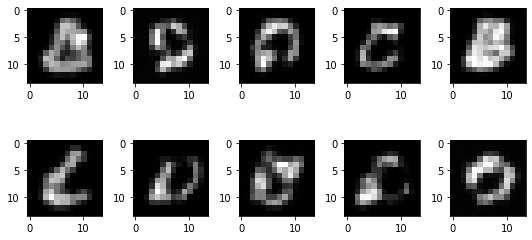

In [80]:
samples = flow.sample(10).detach().cpu()
plot_mnist(samples[:,0], 2, 5)

Pitanja:
1. Objasnite koje ste sve slojeve koristili pri dizajnu SimpleTransform2d.
2. Što se dogodi ako u SimpleTransform2d uključite BatchNorm?